In [1]:
from contrastive_model import ContrastiveModel
import pickle
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
import scanpy as sc

In [2]:
data_path = "../data/tabula_muris/preprocessed/"

full = data_path + "tm_adata_all.pkl"
train = data_path + "tm_adata_train.pkl"
val = data_path + "tm_adata_test.pkl"

with open(val, "rb") as f:
    adata_all = pickle.load(f)

X = adata_all.X.toarray()
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)


In [5]:
job_id = "11352981"
checkpoint_name = "epoch=9-step=23010.ckpt"
version_path = "../lightning_logs/version_" + job_id
model = ContrastiveModel.load_from_checkpoint(version_path + "/checkpoints/" + checkpoint_name)
subset=2024

X_tensor = X_tensor[0:subset]
adata_all = adata_all[0:subset]

model.eval()
batch_size = 64  # Define a suitable batch size
embeddings_list = []


with torch.no_grad():
    for i in tqdm(range(0, X_tensor.size(0), batch_size), desc="Processing Batches"):
        batch = X_tensor[i:i+batch_size]
        batch_embeddings = model(batch).cpu().numpy()
        embeddings_list.append(batch_embeddings)
embeddings = np.concatenate(embeddings_list, axis=0)


Processing Batches: 100%|████████████████████████████████| 32/32 [02:53<00:00,  5.43s/it]


In [9]:
adata_all

AnnData object with n_obs × n_vars = 2024 × 2000
    obs: 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tech'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', 'neighbors', 'umap'
    obsm: 'X_emb', 'X_umap'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f6d64f22fc0>
Traceback (most recent call last):
  File "/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/oscar/rt/9.2/software/0.20-generic/0.20.1/opt/spack/linux-rhel9-x86_64_v3/gcc-11.3.1/anaconda-2023.09-0-7nso27ys7navjquejqdxqylhg7kuyvxo/lib/python3.11/s

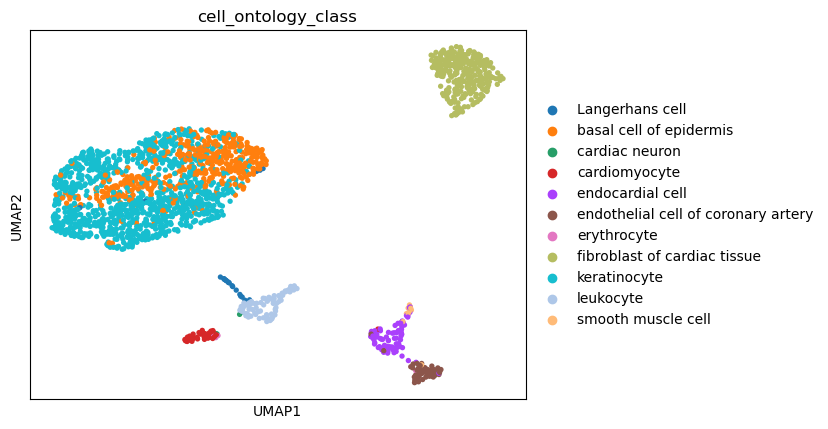

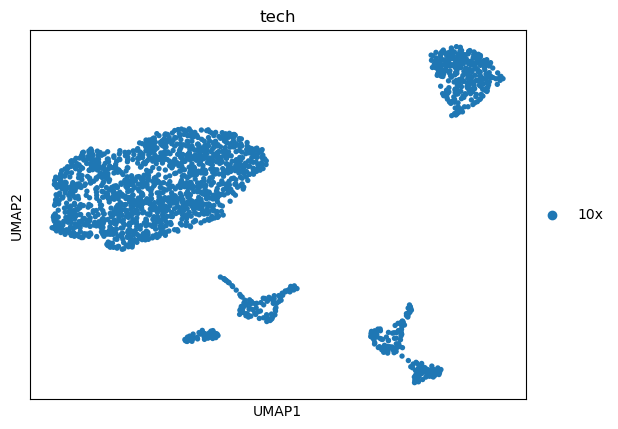

In [10]:
adata_copy = adata_all.copy()
adata_copy.obsm['X_emb'] = embeddings

# Using 'X_emb'
sc.pp.neighbors(adata_all, use_rep='X_emb')
sc.tl.umap(adata_all, n_components=2)

fig1 = sc.pl.umap(
        adata_all, color='cell_ontology_class', show=True, return_fig=True
    )
fig2 = sc.pl.umap(
        adata_all, color='tech', show=True, return_fig=True
    )

In [ ]:
# Using 'X'
adata_copy = adata_all.copy()
sc.pp.neighbors(adata_copy, use_rep='X')
sc.tl.umap(adata_copy, n_components=2)

fig3 = sc.pl.umap(
        adata_copy, color='cell_ontology_class', show=True, return_fig=True
    )
fig4 = sc.pl.umap(
        adata_copy, color='tech', show=True, return_fig=True
    )